In [45]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_squared_log_error, mean_absolute_error

<font size = 8 color = midnightblue> Task 2 Lookalike Model 

## Loading Datasets

In [4]:
customer_data = pd.read_csv("Customers.csv")
product_data = pd.read_csv("Products.csv")
transaction_data = pd.read_csv("Transactions.csv")

data = pd.merge(customer_data,transaction_data,on = 'CustomerID')
data = pd.merge(product_data,data,on = 'ProductID')
data.head()

,ProductID,ProductName,Category,Price_x,CustomerID,CustomerName,Region,SignupDate,TransactionID,TransactionDate,Quantity,TotalValue,Price_y
0,P001,ActiveWear Biography,Books,169.3,C0017,Jennifer King,Europe,2023-12-05,T00758,2024-05-28 14:47:15,3,507.9,169.3
1,P001,ActiveWear Biography,Books,169.3,C0019,Brandon Rodriguez,Europe,2023-01-12,T00088,2024-01-30 17:23:03,2,338.6,169.3
2,P001,ActiveWear Biography,Books,169.3,C0024,Michele Cooley,North America,2024-02-05,T00314,2024-09-24 17:15:16,4,677.2,169.3
3,P001,ActiveWear Biography,Books,169.3,C0036,Brian Aguilar DDS,North America,2024-07-06,T00433,2024-05-05 05:01:18,2,338.6,169.3
4,P001,ActiveWear Biography,Books,169.3,C0045,Michael Williams,Asia,2022-02-25,T00732,2024-08-13 10:42:48,2,338.6,169.3


In [5]:
data.dtypes[data.dtypes == 'object']

ProductID          object
ProductName        object
Category           object
CustomerID         object
CustomerName       object
Region             object
SignupDate         object
TransactionID      object
TransactionDate    object
dtype: object

In [6]:
data.drop(columns=['Price_x'],inplace=True)
data.rename(columns={'Price_y':'Price'},inplace = True)

## Converting Categorical Columns

In [7]:
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['ProductID'] = data['ProductID'].str.split('P',expand=True).drop(columns=[0]).astype(int)
data['CustomerID'] = data['CustomerID'].str.split('C',expand=True).drop(columns=[0]).astype(int)
data['TransactionID'] = data['TransactionID'].str.split('T',expand=True).drop(columns=[0]).astype(int)

In [8]:
data.dtypes[data.dtypes == 'object']

ProductName     object
Category        object
CustomerName    object
Region          object
dtype: object

In [9]:
for col in data.dtypes[data.dtypes == 'object'].index:
    k = data[col].unique().tolist()
    enc = OrdinalEncoder(categories=[k],dtype = int)
    data[col] = enc.fit_transform(data[[col]]) 

## Total Number of Products & Customers

In [10]:
print(f"Total Number of Products : {data['ProductName'].nunique()}")
print(f"Total Number of Customers: {data['CustomerName'].nunique()}")

Total Number of Products : 66
Total Number of Customers: 199


In [11]:
cat_data = pd.merge(customer_data,transaction_data,on = 'CustomerID')
cat_data = pd.merge(product_data,cat_data,on = 'ProductID').drop(columns=['Price_x'])

## Similarity Calculation

In [12]:
cust = data[data.CustomerName == 1].drop(columns = ['SignupDate','TransactionDate']).set_index('CustomerName')
other = data[data.CustomerName != 1].drop(columns=['SignupDate','TransactionDate']).set_index('CustomerName')
similarity = cosine_similarity(cust,other)[1]
similarity = pd.Series(similarity,index = other.index).sort_values(ascending=False)
top3_similar = similarity.sort_values(ascending=False)[:3].index.tolist()
top3_similar

[35, 159, 64]

## Function for similarity Calculation

In [13]:
def similar_customers(customer_name):
    cust = data[data.CustomerName == customer_name].drop(columns = ['SignupDate',
                'TransactionDate']).set_index('CustomerName')
    other = data[data.CustomerName != customer_name].drop(columns = ['SignupDate',
                'TransactionDate']).set_index('CustomerName')
    similarity = cosine_similarity(cust,other)[1]
    similarity = pd.Series(similarity,index = other.index).sort_values(ascending=False)
    top3_similar = similarity.sort_values(ascending=False)[:3].index.tolist()
    return top3_similar

In [14]:
similar_customers(3)

[78, 141, 143]

## Using Customer Name for Similarity Calculation

In [15]:
data['CustomerName'] = cat_data['CustomerName']
data['CustomerName']

0          Jennifer King
1      Brandon Rodriguez
2         Michele Cooley
3      Brian Aguilar DDS
4       Michael Williams
             ...        
995           Scott Sims
996        Abigail Jones
997        Abigail Jones
998        William Adams
999       Jessica Warren
Name: CustomerName, Length: 1000, dtype: object

In [16]:
def similar_customers(customer_name):
    user = data[data.CustomerName == customer_name].drop(columns = ['SignupDate',
                'TransactionDate']).set_index('CustomerName')
    other = data[data.CustomerName != customer_name].drop(columns = ['SignupDate',
                'TransactionDate']).set_index('CustomerName')
    similarity = cosine_similarity(user,other)[1]
    similarity = pd.Series(similarity,index = other.index).sort_values(ascending=False)
    top20_similar = similarity.sort_values(ascending=False)[:3].index.tolist()
    return top20_similar

In [17]:
similar_customers('Jennifer King')

['David Gonzalez', 'Belinda Garner', 'Beth Cardenas']

## Spliting datetime

In [18]:
k=  cat_data['TransactionDate'].str.split(r'[-: ]',expand=True,n = 5).astype(int)
k.rename(columns = {0:'year',1:'month',2:'date',3:'hour',4:'minutes',5:'seconds'},inplace = True)
pd.concat([data,k],axis = 1).drop(columns = 'TransactionDate')

,ProductID,ProductName,Category,CustomerID,CustomerName,Region,SignupDate,TransactionID,Quantity,TotalValue,Price,year,month,date,hour,minutes,seconds
0,1,0,0,17,Jennifer King,0,2023-12-05,758,3,507.90,169.30,2024,5,28,14,47,15
1,1,0,0,19,Brandon Rodriguez,0,2023-01-12,88,2,338.60,169.30,2024,1,30,17,23,3
2,1,0,0,24,Michele Cooley,1,2024-02-05,314,4,677.20,169.30,2024,9,24,17,15,16
3,1,0,0,36,Brian Aguilar DDS,1,2024-07-06,433,2,338.60,169.30,2024,5,5,5,1,18
4,1,0,0,45,Michael Williams,2,2022-02-25,732,2,338.60,169.30,2024,8,13,10,42,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,100,57,3,77,Scott Sims,3,2023-10-18,820,2,252.68,126.34,2024,3,11,10,55,51
996,100,57,3,109,Abigail Jones,1,2022-05-09,283,4,505.36,126.34,2024,7,16,14,50,7
997,100,57,3,109,Abigail Jones,1,2022-05-09,301,2,252.68,126.34,2024,7,13,8,15,45
998,100,57,3,156,William Adams,1,2023-08-19,740,4,505.36,126.34,2024,8,24,19,10,31


## Customer Analysis

In [19]:
tran = data.groupby('CustomerName').agg(Total_Spending = ('TotalValue','sum'),Purchasefrequency = ('TransactionID','count'),
                    Avg_tran = ('TotalValue','mean'),Last_Purchase = ('TransactionDate','max'),Unique = ('ProductID','nunique')).reset_index()
tran

,CustomerName,Total_Spending,Purchasefrequency,Avg_tran,Last_Purchase,Unique
0,Aaron Cox,1717.55,4,429.387500,2024-11-16 18:14:23,4
1,Abigail Jones,5487.25,11,498.840909,2024-11-07 01:47:33,10
2,Aimee Taylor,7572.91,7,1081.844286,2024-11-30 07:11:48,7
3,Albert Burke,5316.46,6,886.076667,2024-11-01 12:16:45,6
4,Alexander Barker,3347.60,6,557.933333,2024-12-27 17:31:24,6
...,...,...,...,...,...,...
194,Wayne Stone,5771.27,8,721.408750,2024-11-26 07:35:05,7
195,Wendy Browning,3716.52,4,929.130000,2024-09-12 09:25:47,4
196,William Adams,7634.45,11,694.040909,2024-12-15 00:35:54,10
197,William Walker,1284.27,2,642.135000,2024-09-30 10:45:06,2


In [20]:
customer = pd.merge(customer_data,tran,on = 'CustomerName')
cat = customer['Region'].unique()
enc = OrdinalEncoder(categories=[cat],dtype = int)
customer['Region'] = enc.fit_transform(customer[['Region']])
customer

,CustomerID,CustomerName,Region,SignupDate,Total_Spending,Purchasefrequency,Avg_tran,Last_Purchase,Unique
0,C0001,Lawrence Carroll,0,2022-07-10,3354.52,5,670.904000,2024-11-02 17:04:16,5
1,C0002,Elizabeth Lutz,1,2022-02-13,1862.74,4,465.685000,2024-12-03 01:41:41,4
2,C0003,Michael Rivera,0,2024-03-07,2725.38,4,681.345000,2024-08-24 18:54:04,4
3,C0004,Kathleen Rodriguez,0,2022-10-09,5354.88,8,669.360000,2024-12-23 14:13:52,8
4,C0005,Laura Weber,1,2022-08-15,2034.24,3,678.080000,2024-11-04 00:30:22,3
...,...,...,...,...,...,...,...,...,...
194,C0196,Laura Watts,3,2022-06-07,4982.88,4,1245.720000,2024-12-15 03:43:35,3
195,C0197,Christina Harvey,3,2023-03-21,1928.65,3,642.883333,2024-12-27 18:20:31,3
196,C0198,Rebecca Ray,3,2022-02-27,931.83,2,465.915000,2024-10-04 18:31:12,2
197,C0199,Andrea Jenkins,3,2022-12-03,1979.28,4,494.820000,2024-10-26 00:01:58,4


## Similarity Matrix

In [21]:
sc = StandardScaler()
customer_sc = sc.fit_transform(customer.drop(columns = ['CustomerID','CustomerName','SignupDate','Last_Purchase']))
similarity_matrix = cosine_similarity(customer_sc)
similarity_df = pd.DataFrame(similarity_matrix,index = customer['CustomerID'],columns = customer['CustomerID'])
similarity_df

CustomerID,C0001,C0002,C0003,C0004,C0005,C0006,C0007,C0008,C0009,C0010,...,C0191,C0192,C0193,C0194,C0195,C0196,C0197,C0198,C0199,C0200
CustomerID,,,,,,,,,,,,,,,,,,,,,
C0001,1.000000,0.310858,0.858481,0.480394,0.250482,0.523793,0.206983,-0.103382,-0.424023,-0.600670,...,0.962756,0.747794,0.437576,-0.277403,0.853985,-0.514802,-0.642028,-0.436497,-0.675368,0.204358
C0002,0.310858,1.000000,0.581890,-0.427219,0.731071,-0.302793,0.296669,-0.310365,0.727645,0.568458,...,0.524484,0.856447,0.415513,-0.300231,-0.082134,-0.637183,0.400988,0.655330,0.489937,-0.756206
C0003,0.858481,0.581890,1.000000,-0.036543,0.709524,0.559787,0.628103,-0.550772,-0.059827,-0.284893,...,0.854643,0.897825,0.804915,-0.675146,0.467085,-0.337297,-0.172696,0.033404,-0.338557,0.068623
C0004,0.480394,-0.427219,-0.036543,1.000000,-0.728191,0.107814,-0.646537,0.719100,-0.759556,-0.717727,...,0.400374,-0.100974,-0.505079,0.590154,0.866519,-0.381594,-0.965229,-0.928725,-0.766443,0.331505
C0005,0.250482,0.731071,0.709524,-0.728191,1.000000,0.269683,0.864712,-0.859860,0.522550,0.339562,...,0.316370,0.704784,0.890766,-0.853048,-0.289625,-0.003072,0.568788,0.692624,0.332866,-0.229716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0196,-0.514802,-0.637183,-0.337297,-0.381594,-0.003072,0.457062,0.421990,-0.448008,-0.227960,-0.148894,...,-0.703541,-0.646064,0.211416,-0.388191,-0.512402,1.000000,0.310093,0.040400,-0.029041,0.642456
C0197,-0.642028,0.400988,-0.172696,-0.965229,0.568788,-0.343811,0.432129,-0.517028,0.847941,0.853108,...,-0.523896,-0.023717,0.273592,-0.360402,-0.939187,0.310093,1.000000,0.951788,0.897526,-0.477913
C0198,-0.436497,0.655330,0.033404,-0.928725,0.692624,-0.401361,0.429237,-0.522247,0.943980,0.894914,...,-0.267557,0.253219,0.339578,-0.384372,-0.802193,0.040400,0.951788,1.000000,0.904674,-0.648951


In [23]:
# Function to get top 3 lookalikes for a given customer
def get_top_lookalikes(customer_id, similarity_df, top_n=3):
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).index[1:top_n+1]
    similarity_scores = similarity_df[customer_id].sort_values(ascending=False).values[1:top_n+1].round(2).tolist()
    return list(zip(similar_customers, similarity_scores))

# Get top 3 lookalikes for the first 20 customers
lookalikes = {}
for customer_id in customer['CustomerID'].head(20):
    lookalikes[customer_id] = get_top_lookalikes(customer_id, similarity_df)

# Convert to DataFrame for saving to CSV
lookalike_df = pd.DataFrame(list(lookalikes.items()), columns=['CustomerID', 'Lookalikes'])


In [24]:
look = pd.DataFrame(lookalike_df['Lookalikes'].tolist(),index=lookalike_df.index)
final_df = pd.concat([lookalike_df.drop('Lookalikes',axis = 1),look],axis = 1).rename(columns = {0:'Similar 1',1:'Similar 2',2:'Similar 3'})
data[data['CustomerID'].isin(final_df['CustomerID'])]

,ProductID,ProductName,Category,CustomerID,CustomerName,Region,SignupDate,TransactionID,TransactionDate,Quantity,TotalValue,Price


In [25]:
final_df.to_csv('Malik_Faizan_Lookalike.csv')

In [26]:
sa = data.groupby('CustomerID')['ProductID'].count()
print(sa.mean().round(2))

5.03


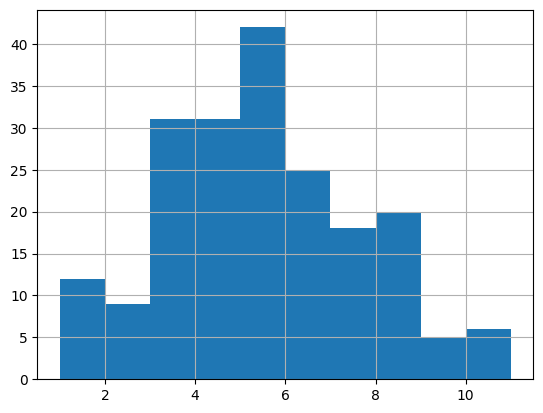

In [27]:
sa.hist()
plt.show()

In [28]:
prod_rec = data.groupby('ProductID')['CustomerID'].count()
prod_rec.mean()

np.float64(10.0)

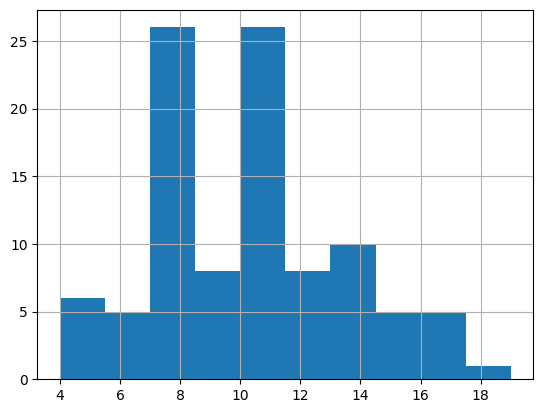

In [29]:
prod_rec.hist()
plt.show()

In [33]:
dt = DecisionTreeRegressor()
data1 = data.drop(columns = ['CustomerName','SignupDate','TransactionDate'])
X = data1.drop(columns = 'TotalValue')
y = data1.TotalValue
x_train,x_test,y_train,y_test = split(X,y,test_size=0.2,random_state=12)
dt.fit(x_train,y_train)

DecisionTreeRegressor()

In [ ]:
y_pred = dt.predict(x_test)

In [44]:
print(f"Decision Tree Train Score: {dt.score(x_train,y_train)*100}%")
print(f"Decision Tree Test Score : {dt.score(x_test,y_test)*100:.2f}%")

Decision Tree Train Score: 100.0%
Decision Tree Test Score : 99.95%


In [54]:
print(f"Mean Squared Error   : {mean_squared_error(y_test,y_pred):.4f}")
print(f"Mean Absolute Error  : {mean_absolute_error(y_test,y_pred):.4f}")
print(f"Mean Square log Error: {mean_squared_log_error(y_test,y_pred):.4f}")

Mean Squared Error   : 112.8626
Mean Absolute Error  : 3.3683
Mean Square log Error: 0.0027


## Prediction for Total Spending of Customers

In [55]:
new_data = pd.DataFrame({
    'ProductID':[5,40,1,34,9],'ProductName':[4,2,78,3,56],'Category':[0,5,23,89,5],'CustomerID':[56,89,23,45,12],'Region':[2,0,1,3,2],
    'TransactionID':[999,1000,1001,1002,1003],'Quantity':[2,3,5,8,2],'Price':[123.0,678.0,340.0,230.0,430]
})
new_data

,ProductID,ProductName,Category,CustomerID,Region,TransactionID,Quantity,Price
0,5,4,0,56,2,999,2,123.0
1,40,2,5,89,0,1000,3,678.0
2,1,78,23,23,1,1001,5,340.0
3,34,3,89,45,3,1002,8,230.0
4,9,56,5,12,2,1003,2,430.0


In [56]:
dt.predict(new_data)

array([ 242.64, 1465.89, 1348.88,  916.24,  855.22])